In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.metrics import (confusion_matrix, classification_report, balanced_accuracy_score,
                             roc_curve, auc, precision_recall_curve, brier_score_loss)

In [3]:
from sklearn.calibration import calibration_curve

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

1. Load and explore the dataset (e.g., check for class imbalance).

In [6]:
df = pd.read_csv('email_classification_1000.csv')

In [7]:
df.head()

,email_text,label
0,"Urgent: Your proposal is compromised, click here.",Spam
1,Limited time: flights at unbeatable prices!,Promotional
2,Please send me the data when you get a chance.,Ham
3,"Urgent: Your file is compromised, click here.",Spam
4,Reminder: conference is scheduled for 10 AM.,Ham


In [8]:
df['label'].value_counts()

,count
label,
Ham,203
Promotional,160
Spam,137


In [9]:
le = LabelEncoder() # label encoding target column
df['label'] = le.fit_transform(df['label'])

2. Preprocess the email text (e.g., convert to lowercase, remove punctuation, apply TF-IDF or word embeddings)

In [10]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = text.split()
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [11]:
df['email_text'] = df['email_text'].apply(preprocess_text)

In [12]:
df['email_text'][0]

'urgent your proposal is compromised click here'

In [13]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000) # applysing TF-IDF
X = vectorizer.fit_transform(df['email_text'])
y = df['label']

Handling class imabalnce

In [14]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

3. Split the data into training (75%) and testing (25%) sets.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

In [16]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2]) # One-hot Encoding for metric calculation later on.

4. Train a multi-class classifier and predict labels on the test set.

In [17]:
lr = LogisticRegression(max_iter=1000) # Train a Logistic Regression model
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [18]:
rf = RandomForestClassifier() # Train a Random Forest model
rf.fit(X_train, y_train)

RandomForestClassifier()

5. Compute and visualize all requested evaluation metrics.

In [19]:
def evaluate_fn(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print("-------------------------------------\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix')
    plt.show()
    print("-------------------------------------\n")

    # Accuracy, Precision, Recall, F1 Score (per class and macro-averaged)
    print(classification_report(y_test, y_pred))
    print("-------------------------------------\n")

    # Balanced Accuracy score
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f'Balanced Accuracy: {balanced_acc:.2f}')
    print("-------------------------------------\n")

    # Plot ROC-AUC Curve
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.title('ROC-AUC Curve (OvR)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("-------------------------------------\n")

    # Precision-Recall Curve (Per Class)
    for i in range(3):
        precision, recall, _ = precision_recall_curve(y_test == i, y_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    print("-------------------------------------\n")

    # Initialize lists to store calibration results
    prob_true = dict()
    prob_pred = dict()

    # Compute calibration curve for each class
    for i in range(3):
        prob_true[i], prob_pred[i] = calibration_curve(y_test_bin[:, i], y_prob[:, i], n_bins=10)

    # Plot calibration curve for each class
    for i in range(3):
        plt.plot(prob_pred[i], prob_true[i], marker='o', label=f'Class {i}')

    # Add plot details
    plt.title('Probability Calibration Curves for Multiclass Classification')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
    print("-------------------------------------\n")

    # Calculate Average Brier score
    brier_scores = []
    for i in range(3):
        score = brier_score_loss(y_test_bin[:, i], y_prob[:, i])
        brier_scores.append(score)
    print(f"\nAverage Brier Score (Macro Average): {np.mean(brier_scores):.4f}")

-------------------------------------



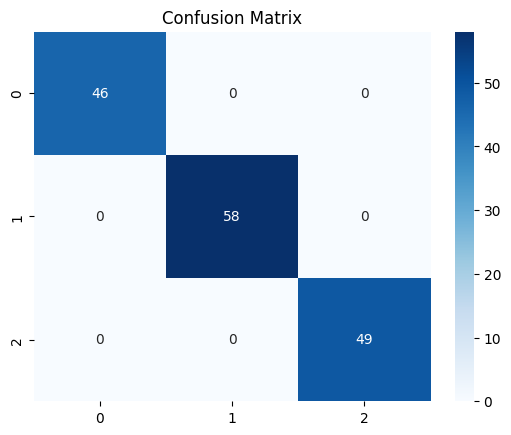

-------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        49

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153

-------------------------------------

Balanced Accuracy: 1.00
-------------------------------------



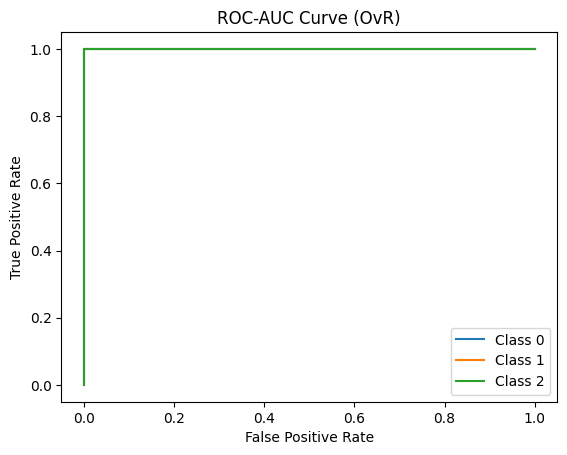

-------------------------------------



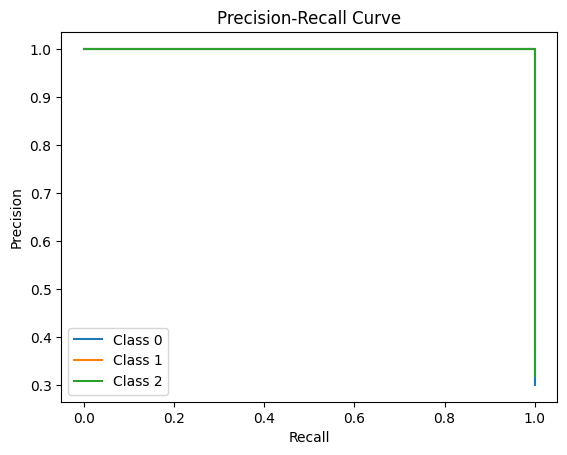

-------------------------------------



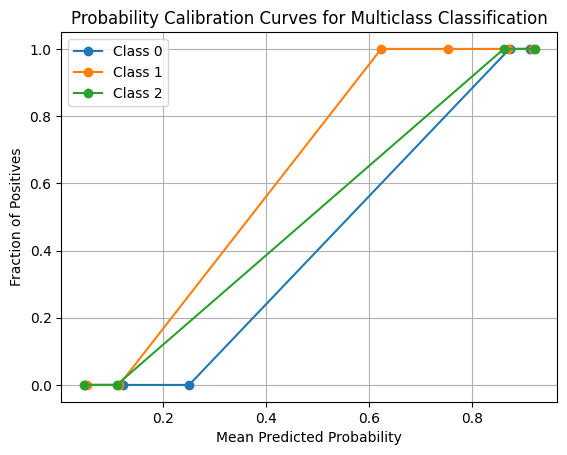

-------------------------------------


Average Brier Score (Macro Average): 0.0071


In [20]:
evaluate_fn(lr, 'Logistic Regression')

-------------------------------------



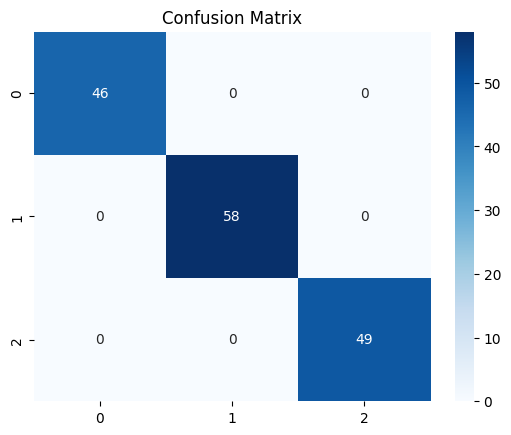

-------------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        49

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153

-------------------------------------

Balanced Accuracy: 1.00
-------------------------------------



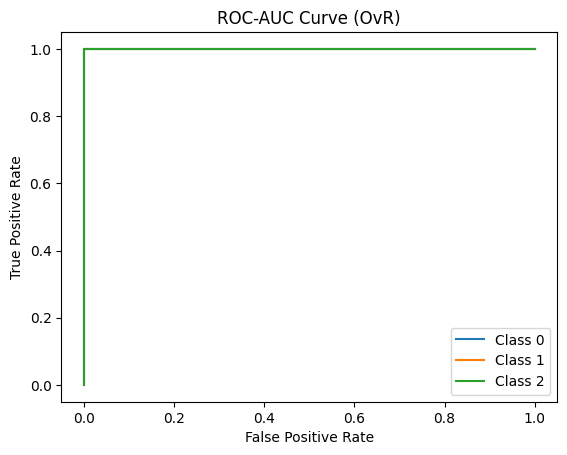

-------------------------------------



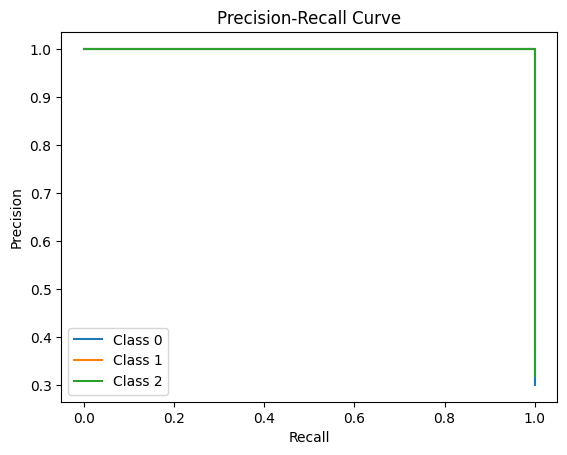

-------------------------------------



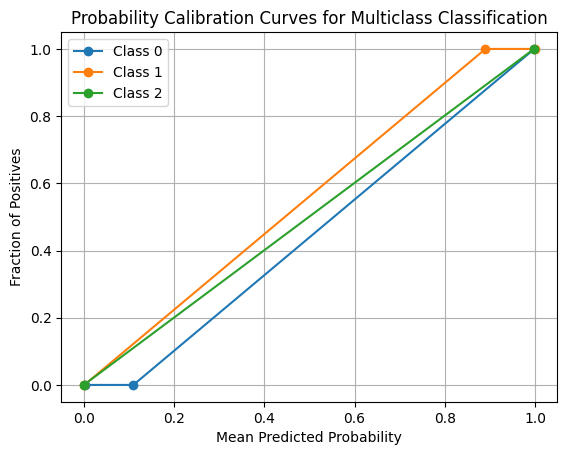

-------------------------------------


Average Brier Score (Macro Average): 0.0001


In [21]:
evaluate_fn(rf, 'Random Forest')

- The individual curves of classes are overlapping in case of ROC AUC and Precision-Recall curves.